In [50]:
import gym
from gym import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [51]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gym.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

                 info: - info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

In [52]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Neural Network for the Stock Trading Agent
class StockTradingNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(StockTradingNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc_pi = nn.Linear(64, action_dim)
        self.fc_v = nn.Linear(64, 1)

    def pi(self, x, softmax_dim=0):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc_pi(x)
        prob = torch.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        v = self.fc_v(x)
        return v

In [53]:
# PPO Agent
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, K_epochs=80, eps_clip=0.2):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.policy = StockTradingNet(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.policy_old = StockTradingNet(state_dim, action_dim)
        self.policy_old.load_state_dict(self.policy.state_dict())

    def select_action(self, state):
        state = F.one_hot(torch.tensor(state), num_classes=4).float().unsqueeze(0)  # One-hot encode and add batch dim
        action_probs = self.policy.pi(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        return action.item(), dist  # Also return the distribution object

    def update(self, memory):
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminal)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        # Convert list to tensor
        old_states = torch.stack(memory.states).detach()
        old_actions = torch.stack(memory.actions).detach()
        old_logprobs = torch.stack(memory.logprobs).detach()

        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)

            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5 * torch.mul(dist_entropy, 0.01)

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())

    def evaluate(self, state, action):
        action_probs = self.policy.pi(state, softmax_dim=-1)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.policy.v(state)

        return action_logprobs, torch.squeeze(state_value), dist_entropy

In [54]:
# Memory Buffer
class MemoryBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminal = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminal[:]

In [55]:
def train(env, agent, num_episodes):
    rewards = []
    account_values = []
    memory = MemoryBuffer()

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action, dist = agent.select_action(state)  # Adjusted to capture the distribution
            next_state, reward, terminated, truncated, info = env.step(action)

            # Convert states to one-hot tensors for storage in memory buffer
            state_tensor = F.one_hot(torch.tensor(state), num_classes=4).float()
            next_state_tensor = F.one_hot(torch.tensor(next_state), num_classes=4).float()

            action_tensor = torch.tensor(action)
            log_prob = dist.log_prob(action_tensor)  # Calculate log probability here

            memory.states.append(state_tensor)
            memory.actions.append(action_tensor)
            memory.logprobs.append(log_prob)  # Use the log probability
            memory.rewards.append(reward)
            memory.is_terminal.append(terminated or truncated)  # Consider episode done if terminated or truncated

            state = next_state  # Move to the next state
            episode_reward += reward

            done = terminated or truncated  # Check if the episode has terminated

        agent.update(memory)  # Update policy
        memory.clear_memory()
        rewards.append(episode_reward)
        account_values.append(env.total_account_value)
        print(f"Episode: {episode + 1}, Total Reward: {episode_reward}, Account Value: {env.total_account_value}")

    return rewards, account_values

Episode: 1, Total Reward: -1291.45624995915, Account Value: 62375.8563990001
Episode: 2, Total Reward: -1019.928652978136, Account Value: 120170.31742100004
Episode: 3, Total Reward: -1586.0372088665042, Account Value: 52542.45701600007
Episode: 4, Total Reward: -1225.1212693300897, Account Value: 112426.32012999998
Episode: 5, Total Reward: -1354.3300600994871, Account Value: 75266.18107200018
Episode: 6, Total Reward: -1449.7151553668698, Account Value: 98844.44815999987
Episode: 7, Total Reward: -1226.4971464505297, Account Value: 93361.77520799979
Episode: 8, Total Reward: -1272.4903834247884, Account Value: 52432.88122700008
Episode: 9, Total Reward: -1202.9780755407958, Account Value: 53877.98203000006
Episode: 10, Total Reward: -1295.6010171911191, Account Value: 100001.62295499996
Episode: 11, Total Reward: -1384.574782402491, Account Value: 82355.309436
Episode: 12, Total Reward: -1109.274162542951, Account Value: 125012.5557709999
Episode: 13, Total Reward: -1066.49694365006,

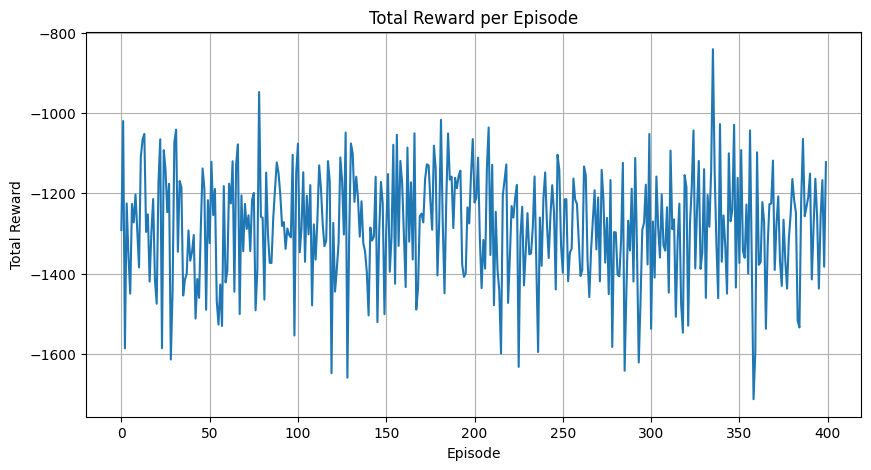

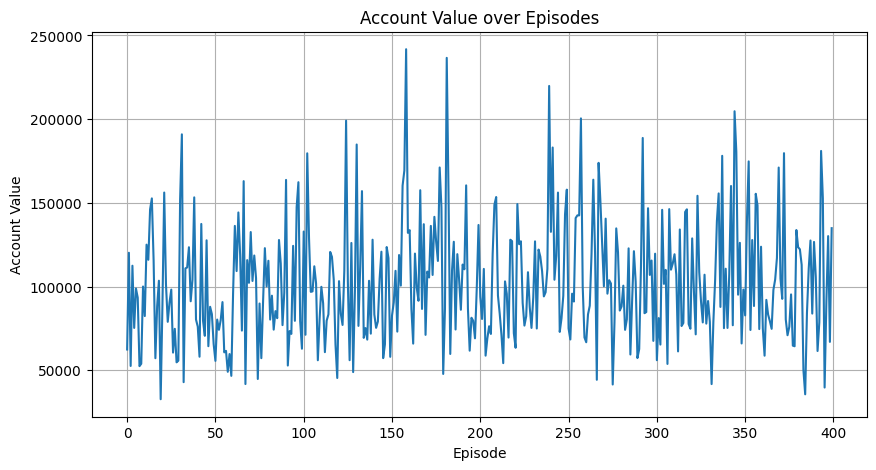

In [56]:
# Initialize your environment and agent
env = StockTradingEnvironment(file_path='./NVDA.csv', number_of_days_to_consider=10)
agent = PPOAgent(state_dim=4, action_dim=env.action_space.n)  # state_dim is 4 due to one-hot encoding

# Training loop
num_episodes = 400
rewards, account_values = train(env, agent, num_episodes)


# Plot the total reward per episode
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

# Plot the account value over episodes
plt.figure(figsize=(10, 5))
plt.plot(account_values)
plt.xlabel('Episode')
plt.ylabel('Account Value')
plt.title('Account Value over Episodes')
plt.grid(True)
plt.show()

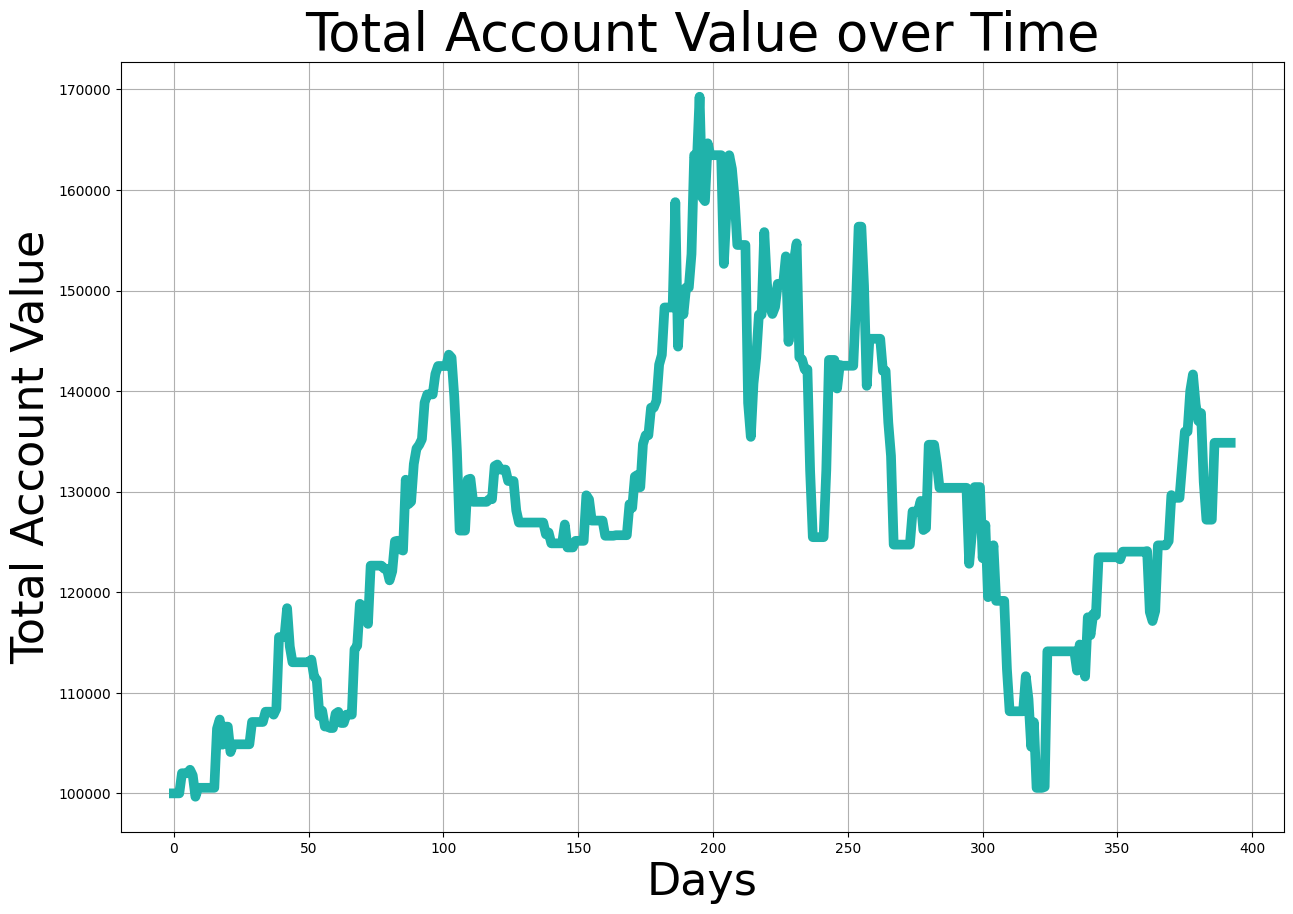

In [57]:
env.render()

In [62]:
def test(env, agent, num_episodes):
    rewards = []
    account_values = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action, _ = agent.select_action(state)  # We ignore the distribution during testing
            next_state, reward, terminated, truncated, info = env.step(action)

            state = next_state
            episode_reward += reward

            done = terminated or truncated

        rewards.append(episode_reward)
        account_values.append(env.total_account_value)
        print(f"Test Episode: {episode + 1}, Total Reward: {episode_reward}, Account Value: {env.total_account_value}")

    return rewards, account_values

Test Episode: 1, Total Reward: -262.1720038701341, Account Value: 100212.33700700005
Test Episode: 2, Total Reward: -297.9310675096971, Account Value: 112377.989398
Test Episode: 3, Total Reward: -142.4095639229952, Account Value: 158123.38815700007
Test Episode: 4, Total Reward: -292.54574863084133, Account Value: 114006.88991499998
Test Episode: 5, Total Reward: -369.3431636029817, Account Value: 119127.47112700001
Test Episode: 6, Total Reward: -226.7655988212863, Account Value: 125708.46524800005
Test Episode: 7, Total Reward: -186.2610763288612, Account Value: 128545.41552599994
Test Episode: 8, Total Reward: -237.50282279087907, Account Value: 106190.57663599995
Test Episode: 9, Total Reward: -240.18320869839053, Account Value: 92443.463464
Test Episode: 10, Total Reward: -240.02108957933837, Account Value: 117838.52675700009
Test Episode: 11, Total Reward: -229.36521639364028, Account Value: 125005.515779
Test Episode: 12, Total Reward: -361.6090681043979, Account Value: 103866.

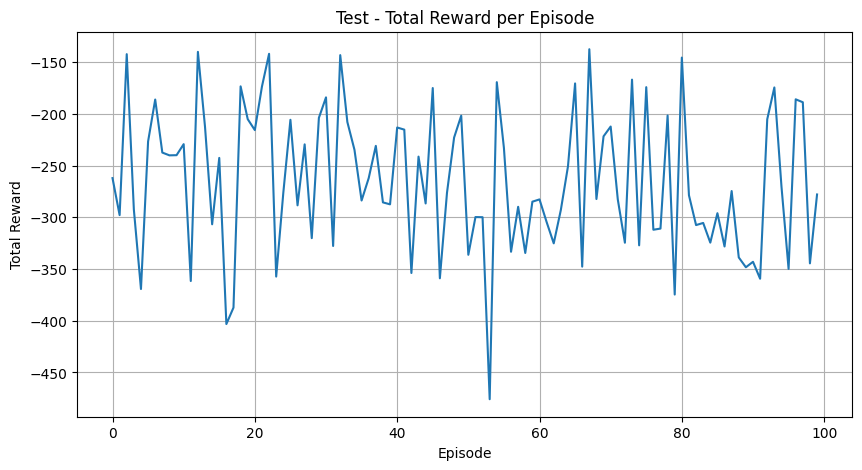

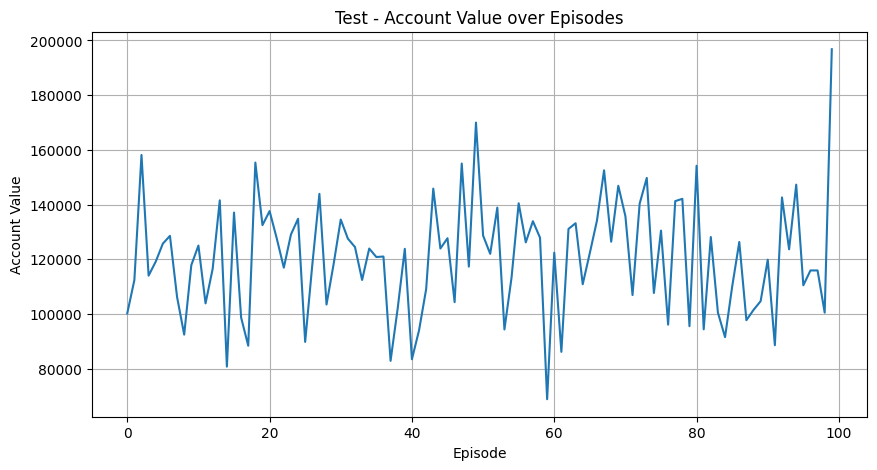

In [63]:
# Initialize the environment in test mode
test_env = StockTradingEnvironment(file_path='./NVDA.csv', train=False, number_of_days_to_consider=10)

# Assuming you have a trained agent already initialized as `agent`
num_test_episodes = 100  # Set the number of test episodes
test_rewards, test_account_values = test(test_env, agent, num_test_episodes)

# Optionally, plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(test_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Test - Total Reward per Episode')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_account_values)
plt.xlabel('Episode')
plt.ylabel('Account Value')
plt.title('Test - Account Value over Episodes')
plt.grid(True)
plt.show()

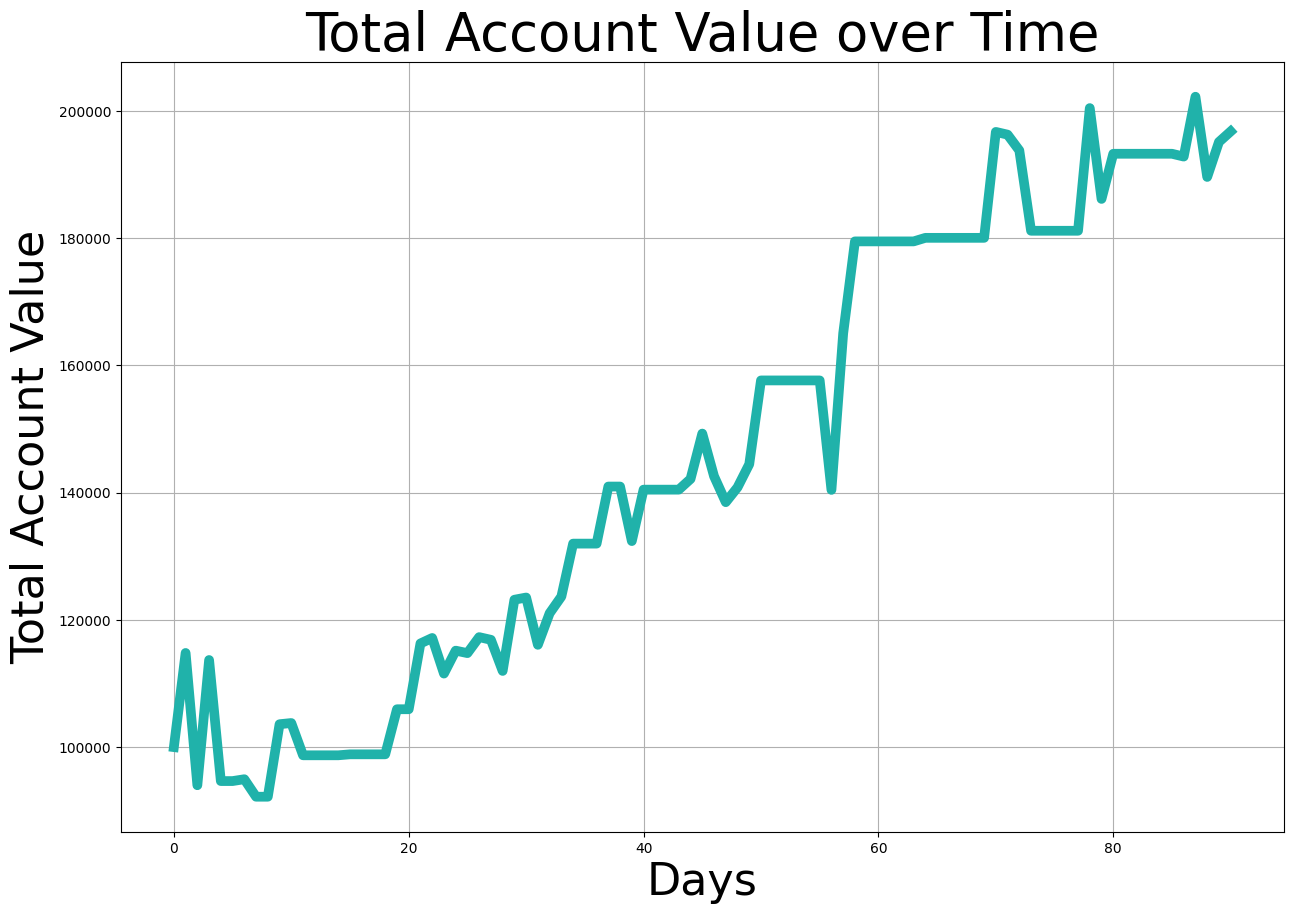

In [64]:
test_env.render()